# Accurate peak finding for the AC TF

In the AC TF extraction, the sample with the underlying pulse maximum must be selected to correctly populate the conversion from ADC to mV. Due to the digitisation noise and the residuals from the pedestal subtraction, the maximum sample in the waveform does not neccessarily correspond to the sample containing the pulse maximum. We must use more intellifent algorithms to find the sample containing the underlying pulse maximum from the waveform.

Viewed from the lowest level, the success of an algorithm depends on how well the underlying pulse time-of-maximum can be extracted, i.e. the time resolution of an algorithm. It is reasonable to expect that the algorithm with the best time resolution results in the AC TF with the lowest standard deviation, and the best resulting charge resolution.

In this notebook we create waveforms with a known true pulse time, digitise the waveforms and include the sample fluctuations we expect (digitisation noise, pedestal subtraction residuals, and different response to amplitude per cell (i.e. the TF itself), and then observe which algorithm is best at reconstruction the true pulse time. We will also compare execution time of the algorithms. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from TargetCalibSB import get_cell_ids_for_waveform
from numba import njit
from tqdm.auto import tqdm, trange
from landau import nb_landau_fit
import iminuit
%matplotlib inline

## Step 1: Define pulse template

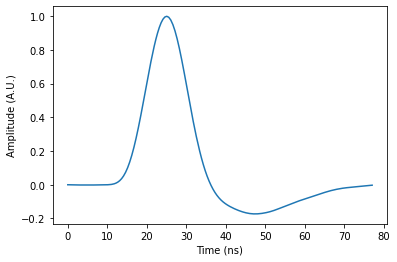

In [21]:
#TODO: Consider other templates in case there is a bias?
template_x_txt, template_y_txt = np.loadtxt("pulse_template_scope.txt", unpack=True)
template_x_txt *= 1e9


template_x = np.linspace(template_x_txt.min(), template_x_txt.max(), 10000)


coeff = {
    'scale0': 980.9780448628237, 
    'mpv0': 27.31295641417644,
    'sigma0': 7.025902256447718,
    'scale1': -892.3469299042976,
    'mpv1': 32.9908323117707,
    'sigma1': 6.728099006162283
}
template_y = nb_landau_fit(template_x, *coeff.values())

#template_y = np.interp(template_x, template_x_txt, template_y_txt)

plt.plot(template_x, template_y)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (A.U.)")

@njit(fastmath=True)
def get_pulse_mV(time, amplitude):
    template_xshift = template_x - template_x[template_y.argmax()] + time

    pulse = np.zeros(128)
    for i in range(template_xshift.size):
        sample = int(template_xshift[i])
        if (sample >= 0) & (sample < 128):
            pulse[sample] += template_y[i] 
    
    pulse /= pulse.max() / amplitude
    return pulse

## Step 2: Create conversion from mV to ADC (from existing TF data)

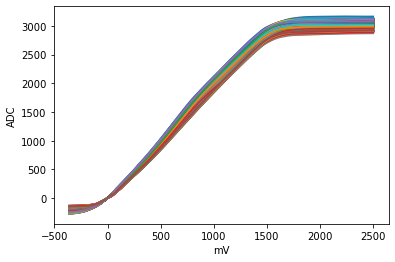

In [22]:
tf_file = np.load("tf.npz")
amplitudes = tf_file['amplitudes']
tf = tf_file['tf']

plt.plot(amplitudes, tf.T)
plt.xlabel("mV")
plt.ylabel("ADC")
        
@njit
def convert_mV_to_ADC(pulse_mV, fci):
    n_samples = pulse_mV.size
    cells = get_cell_ids_for_waveform(fci, n_samples, tf.shape[0])
    adc = np.zeros(n_samples)
    for i in range(n_samples):
        adc[i] = np.interp(pulse_mV[i], amplitudes, tf[cells[i]])
    return adc

## Step 3: Add waveform noise (combined digitisation noise and residuals from pedestal subtraction)

In [23]:
def add_noise(pulse_ADC, sigma):
    return np.random.normal(pulse_ADC, sigma)

## Step 4: Demonstration

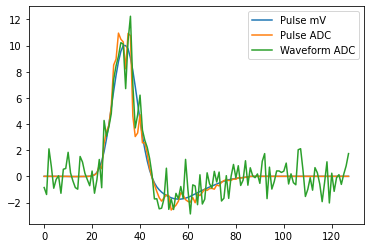

In [24]:
pulse_mV = get_pulse_mV(time=34.1686275, amplitude=10)
pulse_ADC = convert_mV_to_ADC(pulse_mV=pulse_mV, fci=200)
waveform = add_noise(pulse_ADC, 1)
plt.plot(pulse_mV, label="Pulse mV")
plt.plot(pulse_ADC, label="Pulse ADC")
plt.plot(waveform, label="Waveform ADC")
plt.legend()

## Step 5: Define time-of-maximum extraction algorithms

In [25]:
@njit
def argmax(waveform, tmin, tmax, amplitude_mV):
    if amplitude_mV < 0:
        waveform = waveform * -1
    return waveform[tmin:tmax].argmax() + tmin

In [26]:
x_wf = np.arange(128)

@njit
def fit_function(x_wf, y_wf, scale0, mpv0, sigma0, scale1, mpv1, sigma1):
    y_fit = nb_landau_fit(x_wf, scale0, mpv0, sigma0, scale1, mpv1, sigma1)
    error = 1
    chi2 = np.sum((y_wf - y_fit / error) ** 2)
    return chi2

def landau_fit(waveform, tmin, tmax, amplitude_mV):
    def f(scale0, mpv0, sigma0, scale1, mpv1, sigma1):
        return fit_function(x_wf, waveform, scale0, mpv0, sigma0, scale1, mpv1, sigma1)
    
    # Default fit parameter settings
    PEAKPOS = (tmax + tmin) / 2
    if (amplitude_mV > 0.0):
        initial = {
            "scale0": amplitude_mV*11.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 6.0, 
            "scale1": amplitude_mV*(-2.75),
            "mpv1": PEAKPOS+21, 
            "sigma1": 6.5
        }
    elif (amplitude_mV < 0.0):
        initial = {
            "scale0": amplitude_mV*4.0, 
            "mpv0": PEAKPOS, 
            "sigma0": 6.0, 
            "scale1": amplitude_mV*(-1.5),
            "mpv1": PEAKPOS+34, 
            "sigma1": 6.5
        }
    stepsize = {f"error_{key}": value*0.3 for key, value in initial.items()}

    m0 = iminuit.Minuit(f, **stepsize, **initial, print_level=0, pedantic=False, throw_nan=True)
    m0.migrad()

    coeff = m0.values
    y_fit = nb_landau_fit(x_wf, *coeff.values())
    return y_fit.argmax()

In [27]:
from scipy.ndimage import correlate1d
ref_x = np.arange(128)
ref_y = np.interp(ref_x, template_x_txt, template_y_txt)
origin = ref_y.argmax() - ref_y.size // 2

def cross_correlation(waveform, tmin, tmax, amplitude_mV):
    if amplitude_mV < 0:
        waveform = waveform * -1
    cc = correlate1d(waveform, ref_y, mode='constant', origin=origin)
    return cc[tmin:tmax].argmax() + tmin

In [28]:
algorithms = dict(
    argmax=argmax,
    landau_fit=landau_fit,
    cross_correlation=cross_correlation,
)

## Step 6: Run the chain

In [29]:
n_events = 1000
chain_amplitudes = amplitudes[(amplitudes != 0)]
d_list = []
for amplitude_mV in tqdm(chain_amplitudes):
    for iev in range(n_events):
        fci = np.random.randint(0, 4096)
        tmin = 30
        tmax = 40
        time_true = np.random.uniform(tmin, tmax)
        
        pulse_mV = get_pulse_mV(time=time_true, amplitude=amplitude_mV)
        pulse_ADC = convert_mV_to_ADC(pulse_mV=pulse_mV, fci=fci)
        waveform = add_noise(pulse_ADC, 2)
        
        d = dict(amplitude_mV=amplitude_mV, time_true=time_true)
        for name, method in algorithms.items():
            try:
                d[name] = method(waveform, tmin, tmax, amplitude_mV)
            except:
                continue
        d_list.append(d)
df = pd.DataFrame(d_list)

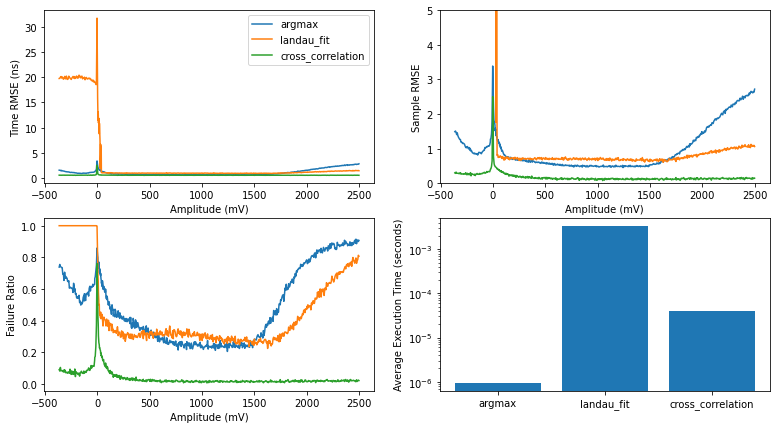

In [31]:
fig = plt.figure(figsize=(13, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

time_name = []
time_value = []
for name, method in algorithms.items():
    df_algorithm = pd.DataFrame(dict(
        time_measured=df[name].values,
        time_true=df['time_true'].values,
        amplitude_mV=df['amplitude_mV'].values,
    )).dropna()
    df_algorithm['time_diff2'] = np.power(df_algorithm['time_measured'] - df_algorithm['time_true'], 2)

    df_algorithm['sample_measured'] = np.floor(df_algorithm['time_measured']).astype(np.int)
    df_algorithm['sample_true'] = np.floor(df_algorithm['time_true']).astype(np.int)
    df_algorithm['sample_diff2'] = np.power(df_algorithm['sample_measured'] - df_algorithm['sample_true'], 2)
    df_algorithm['n'] = 1
    
    df_algorithm['correct'] = df_algorithm['sample_measured'] == df_algorithm['sample_true']

    df_gb = df_algorithm.groupby('amplitude_mV').sum()
    time_rmse = np.sqrt(df_gb['time_diff2'] / df_gb['n'])
    sample_rmse = np.sqrt(df_gb['sample_diff2'] / df_gb['n'])
    success = df_gb['correct'] / df_gb['n']
    failure = 1 - success
    amplitude_mV = df_gb.index.values
    
    # Execution Time
    pulse_mV = get_pulse_mV(time=35, amplitude=10)
    pulse_ADC = convert_mV_to_ADC(pulse_mV=pulse_mV, fci=200)
    waveform = add_noise(pulse_ADC, 1)
    time_name.append(name)
    t = %timeit -q -o -r 1 -n 10 method(waveform, 30, 40, 10)
    time_value.append(t.average)

    ax1.plot(amplitude_mV, time_rmse, label=name)
    ax2.plot(amplitude_mV, sample_rmse)
    ax3.plot(amplitude_mV, failure)

    
ax1.set_xlabel("Amplitude (mV)")
ax1.set_ylabel("Time RMSE (ns)")
ax1.legend()
#ax1.set_ylim(0, 5)

ax2.set_xlabel("Amplitude (mV)")
ax2.set_ylabel("Sample RMSE")
ax2.set_ylim(0, 5)

ax3.set_xlabel("Amplitude (mV)")
ax3.set_ylabel("Failure Ratio")

time_x = np.arange(len(time_name))
ax4.bar(time_x, time_value)
plt.xticks(time_x, time_name)
ax4.set_ylabel("Average Execution Time (seconds)")
ax4.set_yscale('log')

#fig.savefig("result_scope_template.pdf")